In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import os
import time

import requests
import json

IMAGE_SIZE = 128
PATCH_SIZE = 32

In [2]:
def get_mask_fn(img_size, patch_size, use_batch=False):
  patch_start = (img_size - patch_size) // 2
  img_size_after_patch = img_size - (patch_start + patch_size)

  def mask_fn(image):
    """
    Applies a mask of zeroes of size (patch_size x patch_size) at the center of the image.
    Returns a tuple of the masked image and the original image.
    """
    upper_edge = tf.ones([patch_start, img_size, 3], tf.float32)
    lower_edge = tf.ones([img_size_after_patch, img_size, 3], tf.float32)

    middle_left = tf.ones([patch_size, patch_start, 3], tf.float32)
    middle_right = tf.ones([patch_size, img_size_after_patch, 3],
                           tf.float32)

    zeros = tf.zeros([patch_size, patch_size, 3], tf.float32)

    middle = tf.concat([middle_left, zeros, middle_right], axis=1)
    mask = tf.concat([upper_edge, middle, lower_edge], axis=0)

    if use_batch:
      mask = tf.expand_dims(mask, axis=0)

    return image * mask

  return mask_fn

def get_load_and_preprocess_image_fn(masked=False):
  def load_and_preprocess_image(img_filename):
    image_content = tf.read_file(img_filename)

    image = tf.image.decode_jpeg(image_content, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_images(image, [IMAGE_SIZE,
                                                   IMAGE_SIZE])

    if masked:
      mask_image = get_mask_fn(IMAGE_SIZE, PATCH_SIZE)(image)
      return mask_image, image
    else:
      return image

  return load_and_preprocess_image

## Cargar imagen de prueba

200 OK


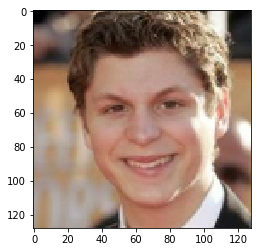

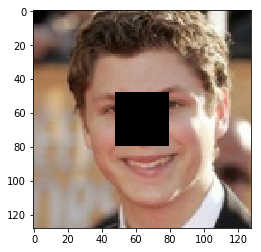

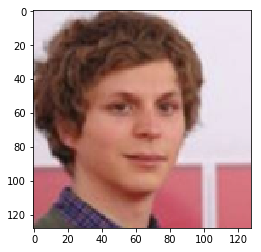

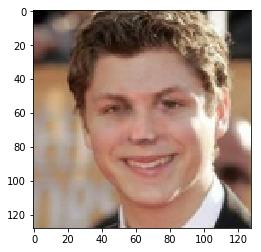

In [9]:
original_filenames = tf.constant([
  "/home/gaston/Pictures/test2/original2.png",])

reference_filenames = tf.constant([
  "/home/gaston/Pictures/test2/ref2.png",])

original_dataset = tf.data.Dataset.from_tensor_slices(original_filenames)
original_dataset = original_dataset.map(get_load_and_preprocess_image_fn(masked=True))


reference_dataset = tf.data.Dataset.from_tensor_slices(reference_filenames)
reference_dataset = reference_dataset.map(get_load_and_preprocess_image_fn(masked=False))

dataset = tf.data.Dataset.zip((original_dataset, reference_dataset))

iterator = dataset.make_one_shot_iterator()

with tf.Session() as sess:
  ((masked, original), reference) = sess.run(iterator.get_next())
  plt.figure()
  plt.imshow(original)
  plt.figure()
  plt.imshow(masked)
  plt.figure()
  plt.imshow(reference)
  
  
  masked_batch = np.expand_dims(masked, axis=0)
  reference_batch = np.expand_dims(reference, axis=0)
  
  masked_json = json.dumps(masked_batch.tolist(), separators=(',', ':'))
  reference_json = json.dumps(reference_batch.tolist(), separators=(',', ':'))
  
  r = requests.post("http://localhost:8501/v1/models/two_face_model:predict",
                  data='{"inputs": {"masked_image":' + masked_json + ', "reference_image":' + reference_json + '}}')
  print(r.status_code, r.reason)
  result = json.loads(r.text)
  result_image = np.array(result['outputs'])
  
  plt.figure()
  plt.imshow(result_image[0])

200 OK


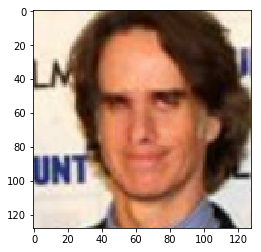

In [4]:
original_filenames = tf.constant([
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005366/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005367/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005370/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005371/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005373/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005376/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005378/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005379/001.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005381/001.jpg"])

reference_filenames = tf.constant([
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005366/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005367/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005370/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005371/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005373/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005376/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005378/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005379/002.jpg",
  "/home/gaston/workspace/datasets/CASIA-WebFace/CASIA-WebFace/data/val_data/validation/real/0005381/002.jpg"])

original_dataset = tf.data.Dataset.from_tensor_slices(original_filenames)
original_dataset = original_dataset.map(get_load_and_preprocess_image_fn(masked=True))

reference_dataset = tf.data.Dataset.from_tensor_slices(reference_filenames)
reference_dataset = reference_dataset.map(get_load_and_preprocess_image_fn(masked=False))

dataset = tf.data.Dataset.zip((original_dataset, reference_dataset)).batch(9)

iterator = dataset.make_one_shot_iterator()

with tf.Session() as sess:
  ((masked_batch, original_batch), reference_batch) = sess.run(iterator.get_next())
  
  masked_json = json.dumps(masked_batch.tolist(), separators=(',', ':'))
  reference_json = json.dumps(reference_batch.tolist(), separators=(',', ':'))
  
  r = requests.post("http://localhost:8501/v1/models/two_face_model:predict",
                  data='{"inputs": {"masked_image":' + masked_json + ', "reference_image":' + reference_json + '}}')
  print(r.status_code, r.reason)
  result = json.loads(r.text)
  result_image = np.array(result['outputs'])
  
  plt.figure()
  plt.imshow(result_image[0])